# Apply kotsu to sktime

# Apply to sktime

In [13]:
import warnings

warnings.filterwarnings("ignore")

import kotsu

from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA

# All forecasters
from sktime.forecasting.bats import BATS
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.naive import NaiveForecaster, NaiveVariance
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.structural import UnobservedComponents
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import TrendForecaster
from sktime.performance_metrics.forecasting import MeanSquaredPercentageError
from sktime.utils.plotting import plot_series

# from sktime.forecasting.conformal import  ConformalIntervals
# from sktime.forecasting.arima import AutoARIMA
# from sktime.forecasting.fbprophet import Prophet
# from sktime.forecasting.var import VAR

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

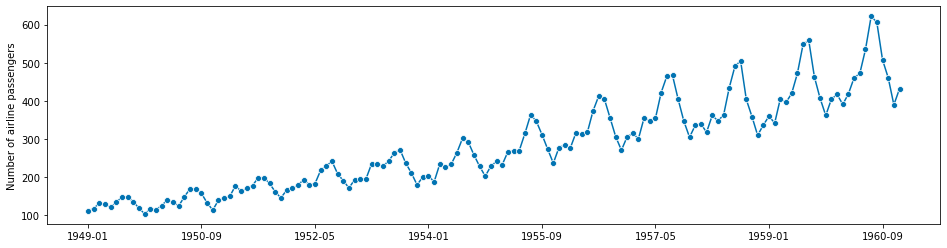

In [14]:
# in the example, we use the airline data set.
y = load_airline()
plot_series(y)

## Register sktime's `estimators`

### Register competing models:

Here we register two different estimators.

In [15]:
model_registry_sktime = kotsu.registration.ModelRegistry()

model_registry_sktime.register(
    id="Naive-v1",
    entry_point=NaiveForecaster,
    kwargs={"strategy": "mean", "sp": 12},
)

model_registry_sktime.register(
    id="ETS-v1",
    entry_point=AutoETS,
    kwargs={"auto": "True", "n_jobs": -1, "sp": 12},
)

model_registry_sktime.register(
    id="Bats-v1",
    entry_point=BATS,
    kwargs={
        "use_box_cox": False,
        "use_trend": True,
        "use_damped_trend": False,
        "sp": 12,
        "use_arma_errors": False,
        "n_jobs": 1,
    },
)

model_registry_sktime.register(
    id="ExponentialSmoothing-v1",
    entry_point=ExponentialSmoothing,
    kwargs={"trend": "add", "seasonal": "multiplicative", "sp": 12},
)

model_registry_sktime.register(
    id="Sarimax-v1",
    entry_point=SARIMAX,
    kwargs={"order": (1, 0, 0), "trend": "t", "seasonal_order": (1, 0, 0, 6)},
)

model_registry_sktime.register(
    id="TBATS-v1",
    entry_point=TBATS,
    kwargs={
        "use_box_cox": False,
        "use_trend": True,
        "use_damped_trend": False,
        "sp": 12,
        "use_arma_errors": False,
        "n_jobs": 1,
    },
)

model_registry_sktime.register(
    id="Theta-v1",
    entry_point=ThetaForecaster,
    kwargs={"sp": 12},
)

model_registry_sktime.register(
    id="Trend-v1",
    entry_point=TrendForecaster,
    kwargs={},
)

model_registry_sktime.register(
    id="StatsForecastAutoARIMA-v1",
    entry_point=StatsForecastAutoARIMA,
    kwargs={"sp": 12},
)

# These estimators don't work with kotsu yet
# model_registry_sktime.register(
#    id="Arima-v1",
#    entry_point=AutoARIMA,
#    kwargs={"sp": 12,  "d": 0, "max_p": 2, "max_q":2, "suppress_warnings": True},
# )

# model_registry_sktime.register(
#    id="Prophet-v1",
#    entry_point=Prophet,
#    kwargs={"seasonality_mode": "multiplicative", "yearly_seasonality": "auto"},
# )

# model_registry_sktime.register(
#    id="Var-v1",
#    entry_point=VAR,
#    kwargs={"method": "ols", "trend": "ct"},
# )

### Register your validations:

We can register multiple validations if we want to compare models in different scenarios, e.g. on different datasets. The validations should take an instance of your models as an argument, then return a the results from validation of that model - return format depoends on output of the CV splitter. Here we register only one Cross-Validation validations that tests 2 models.

The CV splitter to be used here is `evaluate`

In [16]:
validation_registry_sktime = kotsu.registration.ValidationRegistry()


def factory_airline_cross_validation():
    """Factory for airline cross validation."""

    def airline_cross_validation(model):
        """Airline dataset cross validation."""
        y = load_airline()
        cv = ExpandingWindowSplitter(
            initial_window=24,
            step_length=12,
            fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        )
        scores = evaluate(
            forecaster=model, y=y, cv=cv, scoring=MeanSquaredPercentageError()
        )
        return scores

    return airline_cross_validation


validation_registry_sktime.register(
    id="airline_cross_validation-v1",
    entry_point=factory_airline_cross_validation,
)

### Run the model through the validations

In [17]:
kotsu.run.run(model_registry_sktime, validation_registry_sktime, "./kotsu_results.csv")

## Predict Interval

All estimators that can do pred_int are shown below

In [18]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster", filter_tags={"capability:pred_int": True}, as_dataframe=True
)

,name,estimator
0,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
1,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
2,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
3,BATS,<class 'sktime.forecasting.bats.BATS'>
4,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
5,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
6,ForecastX,<class 'sktime.forecasting.compose._pipeline.F...
7,ForecastingGridSearchCV,<class 'sktime.forecasting.model_selection._tu...
8,ForecastingPipeline,<class 'sktime.forecasting.compose._pipeline.F...
9,ForecastingRandomizedSearchCV,<class 'sktime.forecasting.model_selection._tu...


We have to register the models again to figure out which estimators don't work

In [19]:
model_registry_sktime_interval = kotsu.registration.ModelRegistry()

# These estimators don't work with kotsu yet
model_registry_sktime_interval.register(
    id="Arima-v1",
    entry_point=ARIMA,
    kwargs={
        "order": (1, 1, 0),
        "seasonal_order": (0, 1, 0, 12),
        "suppress_warnings": True,
        "suppress_warnings": True,
    },
)

model_registry_sktime_interval.register(
    id="ETS-v1",
    entry_point=AutoETS,
    kwargs={"auto": "True", "n_jobs": -1, "sp": 12},
)

model_registry_sktime_interval.register(
    id="Bats-v1",
    entry_point=BATS,
    kwargs={
        "use_box_cox": False,
        "use_trend": True,
        "use_damped_trend": False,
        "sp": 12,
        "use_arma_errors": False,
        "n_jobs": 1,
    },
)

model_registry_sktime_interval.register(
    id="NaiveVariance-v1",
    entry_point=NaiveVariance,
    kwargs={"forecaster": NaiveForecaster(strategy="drift")},
)

model_registry_sktime_interval.register(
    id="StatsForecastAutoARIMA-v1",
    entry_point=StatsForecastAutoARIMA,
    kwargs={"sp": 12},
)

model_registry_sktime_interval.register(
    id="Theta-v1",
    entry_point=ThetaForecaster,
    kwargs={"sp": 12},
)

model_registry_sktime_interval.register(
    id="Theta-v1",
    entry_point=UnobservedComponents,
    kwargs={"level": "local linear trend"},
)

# model_registry_sktime_interval.register(
#    id="Conformal-v1",
#    entry_point=ConformalIntervals,
#    kwargs={"forecaster": "NaiveForecaster(strategy="drift")"},
# )

# These estimators don't work with kotsu yet
# model_registry_sktime_interval.register(
#    id="AutoArima-v1",
#    entry_point=AutoARIMA,
#    kwargs={"sp": 12,  "d": 0, "max_p": 2, "max_q":2,
# "suppress_warnings": True},
# )

# model_registry_sktime_interval.register(
#    id="Prophet-v1",
#    entry_point=Prophet,
#    kwargs={"seasonality_mode": "multiplicative",
# "yearly_seasonality": "auto"},
# )

# model_registry_sktime_interval.register(
#    id="Var-v1",
#    entry_point=VAR,
#    kwargs={"method": "ols", "trend": "ct"},
# )

Next, register validation. Note the use of PinBallLoss instead of MAE. The metrics determine the type of predict that will be used.

In [20]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

validation_registry_sktime_interval = kotsu.registration.ValidationRegistry()


def factory_airline_cross_validation():
    """Factory for airline cross validation."""

    def airline_cross_validation(model):
        """Airline dataset cross validation."""
        y = load_airline()
        cv = ExpandingWindowSplitter(
            initial_window=24,
            step_length=12,
            fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        )
        loss = PinballLoss()
        # default is score_average=True and multi_output="uniform_average",
        # so gives a number
        scores = evaluate(forecaster=model, y=y, cv=cv, strategy="refit", scoring=loss)
        return scores

    return airline_cross_validation


validation_registry_sktime_interval.register(
    id="airline_cross_validation-v2",
    entry_point=factory_airline_cross_validation,
)

Run the validation

In [21]:
kotsu.run.run(
    model_registry_sktime_interval,
    validation_registry_sktime_interval,
    "./kotsu_results_interval.csv",
)